# Packages Import

In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics as stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [284]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("pastel")

# Data Import

In [285]:
customers = pd.read_csv("customers.csv")

In [286]:
customers.head()

,Unnamed: 0,customer_unique_id,order_frequency,total_price,mean_order_price,mean_item_count,mean_category_count,review_score,comment,mean_installment_payment_value,payment_type_count,late_delivery,recency
0,0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,1.0,1.0,5.0,1.0,141.90,1.0,0,111
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,1.0,1.0,4.0,0.0,27.19,1.0,0,114
2,2,0000f46a3911fa3c0805444483337064,1,86.22,86.22,1.0,1.0,3.0,0.0,86.22,1.0,0,536
3,3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,1.0,1.0,4.0,1.0,43.62,1.0,0,320
4,4,0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,1.0,1.0,5.0,0.0,196.89,1.0,0,287


In [287]:
customers.drop(columns=["Unnamed: 0", "customer_unique_id"], inplace=True)

# Analysis

## Correlations

<Axes: >

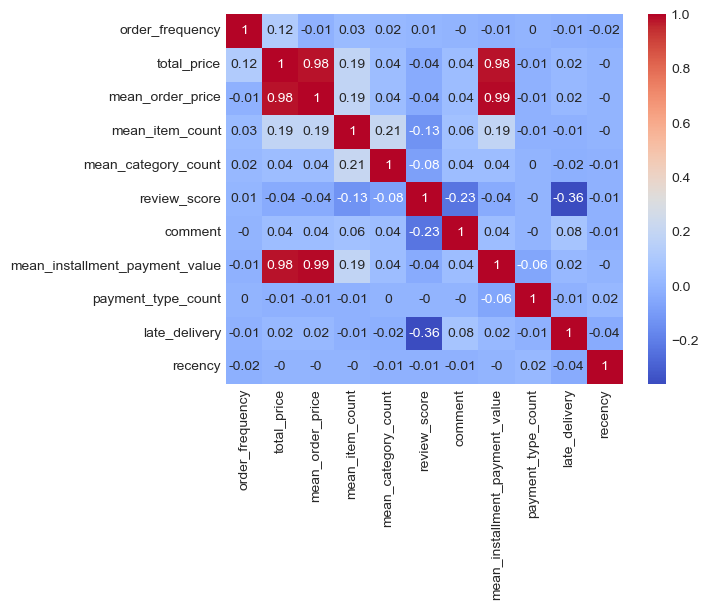

In [288]:
sns.heatmap(
    data=customers.corr(numeric_only=True).round(2),
    cmap="coolwarm",
    annot=True,
)

We will drop features that are too correlated as they seem to be redundant.

In [289]:
customers.drop(
    columns=["mean_order_price", "mean_installment_payment_value"], inplace=True
)

## Distributions

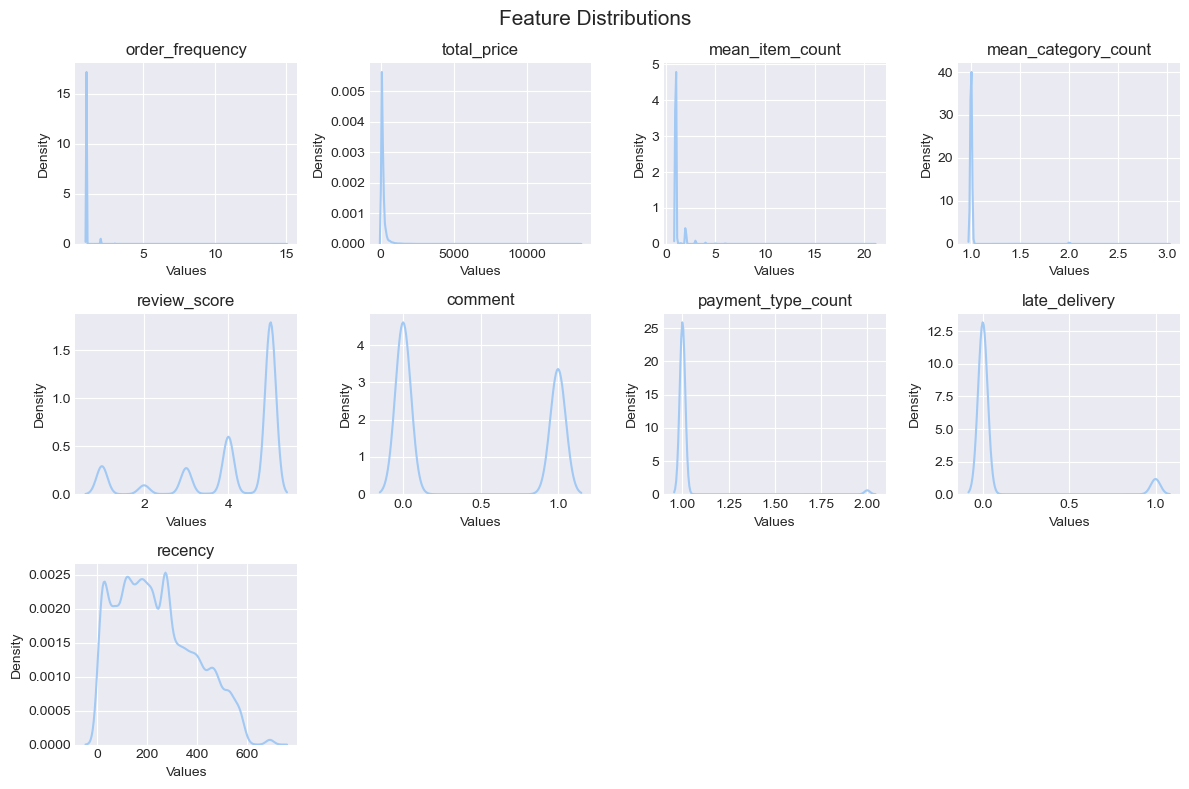

In [290]:
def kde_plots(df):
    columns = df.columns
    n_cols = 4
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 8))
    for i, column in enumerate(columns):
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = axes[row_idx, col_idx]

        sns.kdeplot(df[column], ax=ax)

        ax.set_title(f"{column}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")

    if i + 1 < n_rows * n_cols:
        for j in range(i + 1, n_rows * n_cols):
            axes.flat[j].set_visible(False)

    fig.suptitle("Feature Distributions", fontsize=15)
    plt.tight_layout()
    plt.show()


kde_plots(customers)

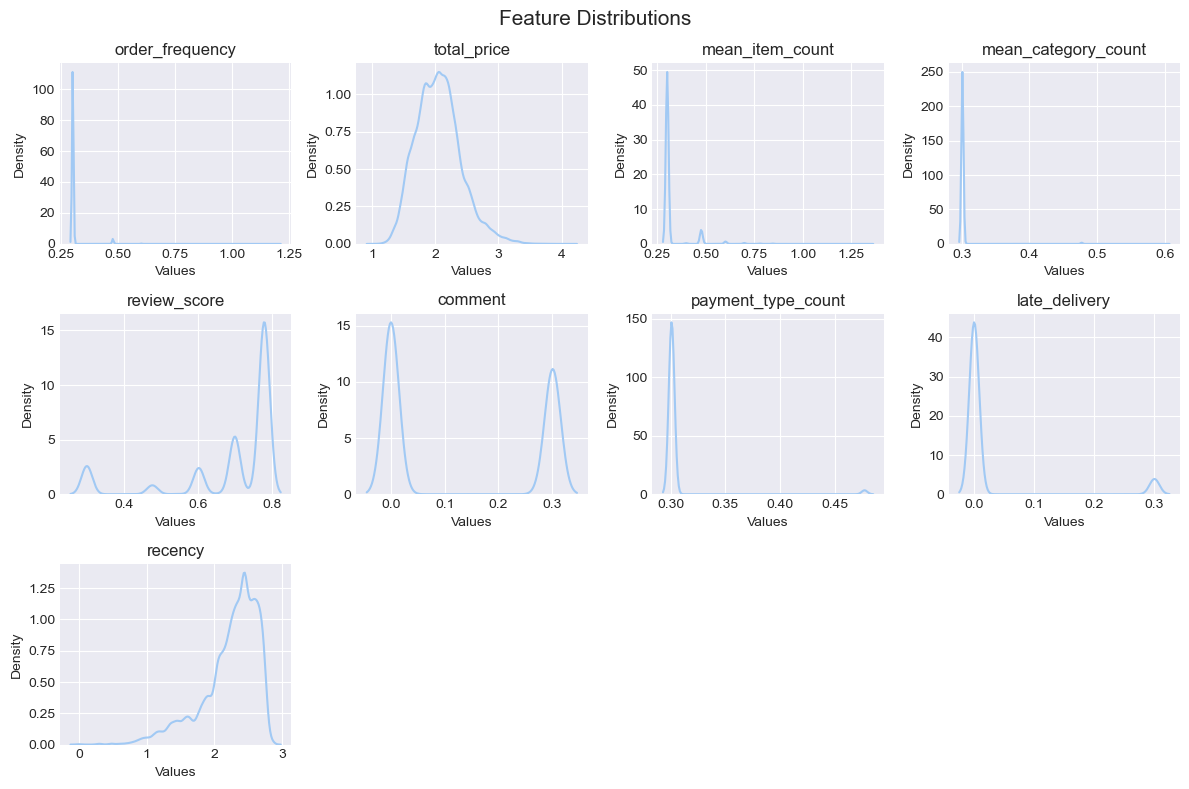

In [291]:
transformed_customers = np.log10(customers + 1)

kde_plots(transformed_customers)

## PCA

In [312]:
transformed_customers.shape

(93358, 9)

In [293]:
def scree_plot(pca, feature_count):
    variance_ratio = (pca.explained_variance_ratio_ * 100).round(2)
    variance_ratio_cum = variance_ratio.cumsum().round()

    x_list = range(1, feature_count + 1)
    plt.bar(x_list, variance_ratio)
    for index, value in enumerate(variance_ratio):
        plt.text(index + 1, value, str(value), ha="center", va="bottom")
    plt.xticks(np.arange(0, feature_count + 1, 1))
    plt.plot(x_list, variance_ratio_cum, c="red", marker="o")
    plt.xlabel("Components")
    plt.ylabel("Variance ratio")
    plt.title("Scree plot")
    plt.show()

In [294]:
def plot_correlation_circle(pca, features, components):
    fig = plt.figure(figsize=(12, 8))
    num = 0
    for x, y in components:
        num += 1
        ax = plt.subplot(1, 2, num)
        for i in range(0, pca.components_.shape[1]):
            ax.arrow(
                0,
                0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.04,
                head_length=0.04,
                width=0.02,
            )
            ax.text(
                pca.components_[x, i] +
                0.02, pca.components_[y, i] + 0.02, features[i]
            )
        plt.plot([-1, 1], [0, 0], color="grey", ls="--")
        plt.plot([0, 0], [-1, 1], color="grey", ls="--")

        ax.set_xlabel(
            "F{} ({}%)".format(
                x + 1, round(100 * pca.explained_variance_ratio_[x], 1))
        )
        ax.set_ylabel(
            "F{} ({}%)".format(
                y + 1, round(100 * pca.explained_variance_ratio_[y], 1))
        )
        ax.set_title("Correlations (F{} et F{})".format(x + 1, y + 1))
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))
        plt.axis("equal")
    plt.show()

In [307]:
def display_factorial_planes(X_projected, components, pca):
    X_ = np.array(X_projected)
    fig = plt.figure(figsize=(15, 5))
    num = 0
    for x, y in components:
        num += 1
        ax = plt.subplot(1, 2, num)

        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], ax=ax)

        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"

        ax.set_xlabel(f"F{x+1} {v1}")
        ax.set_ylabel(f"F{y+1} {v2}")

        x_max = np.abs(X_[:, x]).max() * 1.1
        y_max = np.abs(X_[:, y]).max() * 1.1

        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom=-y_max, top=y_max)

        plt.plot([-x_max, x_max], [0, 0], color="grey", alpha=0.8)
        plt.plot([0, 0], [-y_max, y_max], color="grey", alpha=0.8)
    plt.show()

In [310]:
def scale(df):
    scaler = RobustScaler()
    return scaler.fit_transform(df)

### PCA on all features 

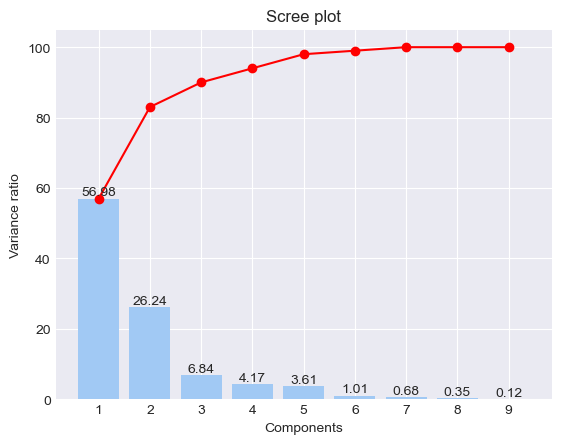

In [334]:
feature_count = len(customers.columns)
pca = PCA(n_components=feature_count)
scaled_data = scale(customers)
pca.fit(scaled_data)
scree_plot(pca, feature_count)

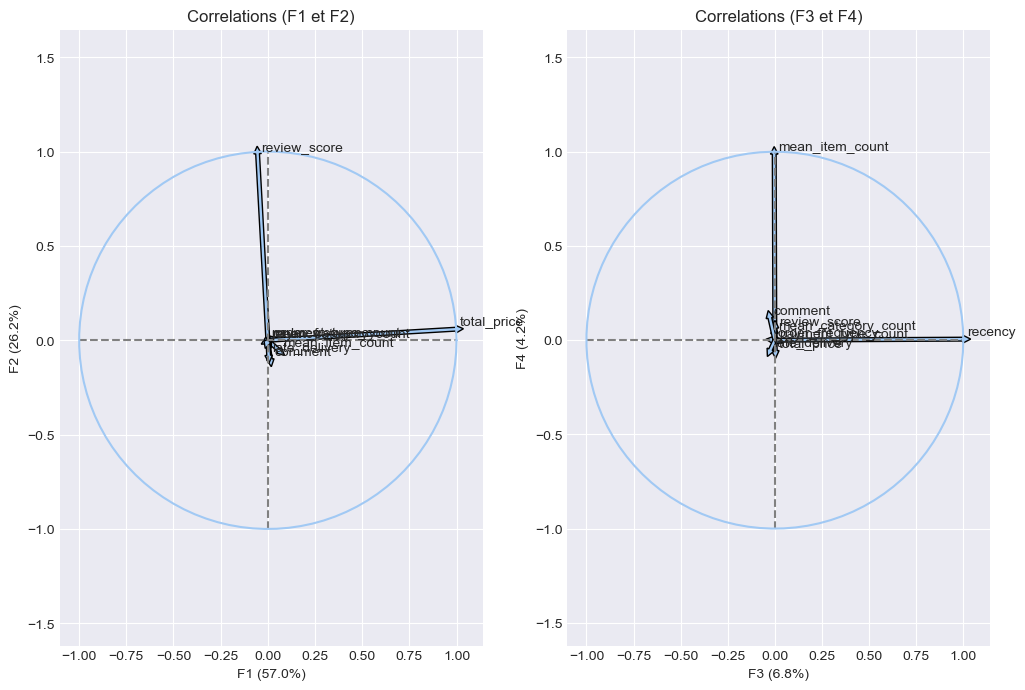

In [336]:
plot_correlation_circle(pca, customers.columns, [(0, 1), (2, 3)])

It seems the first component explains most of the variance of our customer data set. 

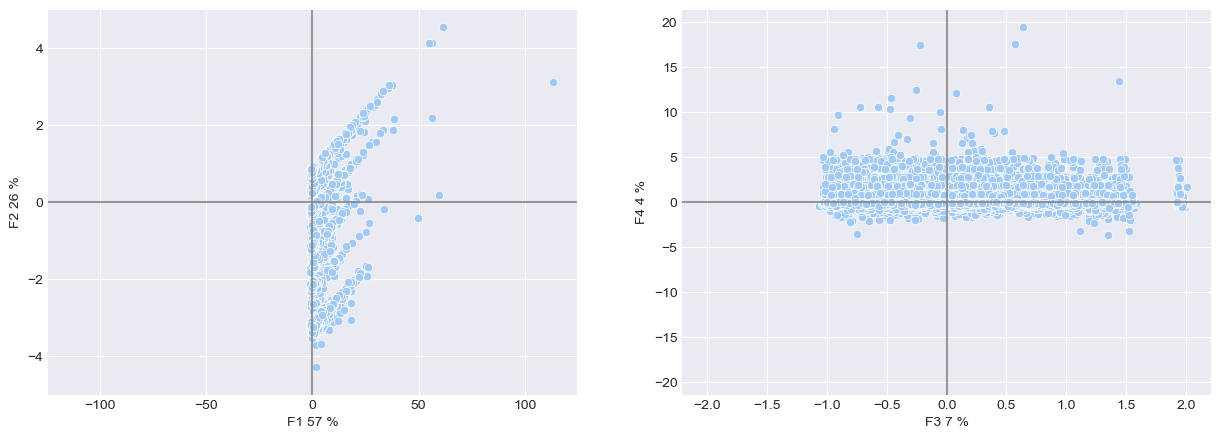

In [337]:
display_factorial_planes(pca.transform(scaled_data), [(0, 1), (2, 3)], pca)

### RFM PCA 

We'll perform the PCA on RFM features 

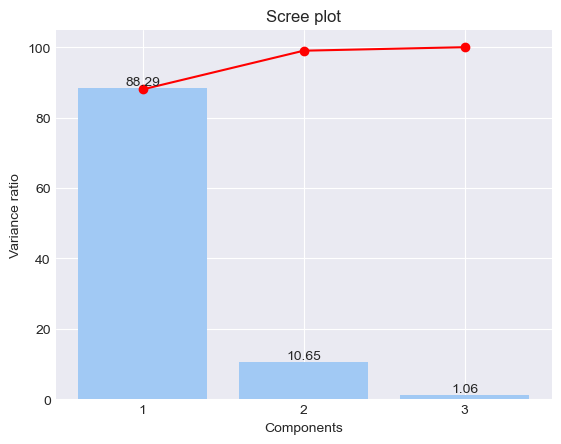

In [352]:
rfm_subset = customers[["order_frequency", "total_price", "recency"]]

rfm_pca = PCA(n_components=3)
scaled_data = scale(rfm_subset)
rfm_pca.fit(scaled_data)
scree_plot(rfm_pca, 3)

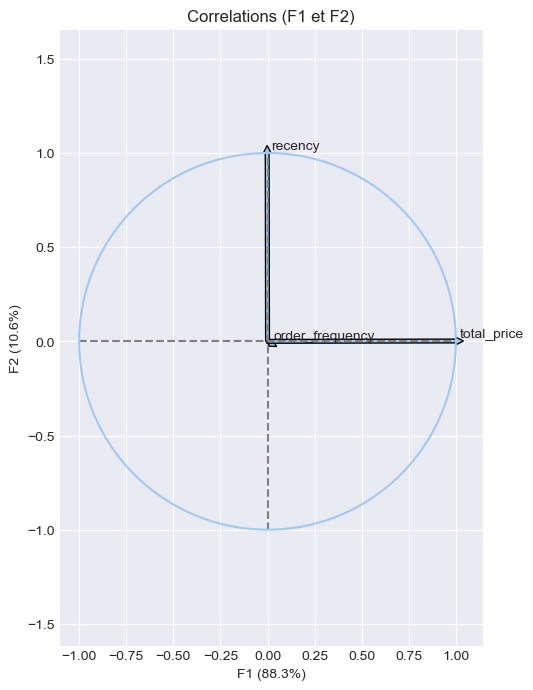

In [354]:
plot_correlation_circle(rfm_pca, rfm_subset.columns, [(0, 1)])

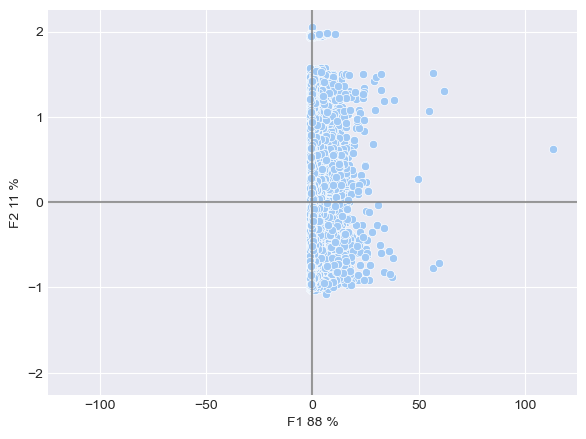

In [356]:
rfm_projected = pca.transform(scaled_data)
display_factorial_planes(rfm_projected, [(0, 1)], pca)

We'll use TSNE to see if we can capture other relationships in the data where the PCA cannot

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 93358 samples in 0.024s...
[t-SNE] Computed neighbors for 93358 samples in 0.952s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93358
[t-SNE] Computed conditional probabilities for sample 2000 / 93358
[t-SNE] Computed conditional probabilities for sample 3000 / 93358
[t-SNE] Computed conditional probabilities for sample 4000 / 93358
[t-SNE] Computed conditional probabilities for sample 5000 / 93358
[t-SNE] Computed conditional probabilities for sample 6000 / 93358
[t-SNE] Computed conditional probabilities for sample 7000 / 93358
[t-SNE] Computed conditional probabilities for sample 8000 / 93358
[t-SNE] Computed conditional probabilities for sample 9000 / 93358
[t-SNE] Computed conditional probabilities for sample 10000 / 93358
[t-SNE] Computed conditional probabilities for sample 11000 / 93358
[t-SNE] Computed conditional probabilities for sample 12000 / 93358
[t-SNE] Computed conditional probabilities for sa

<Axes: >

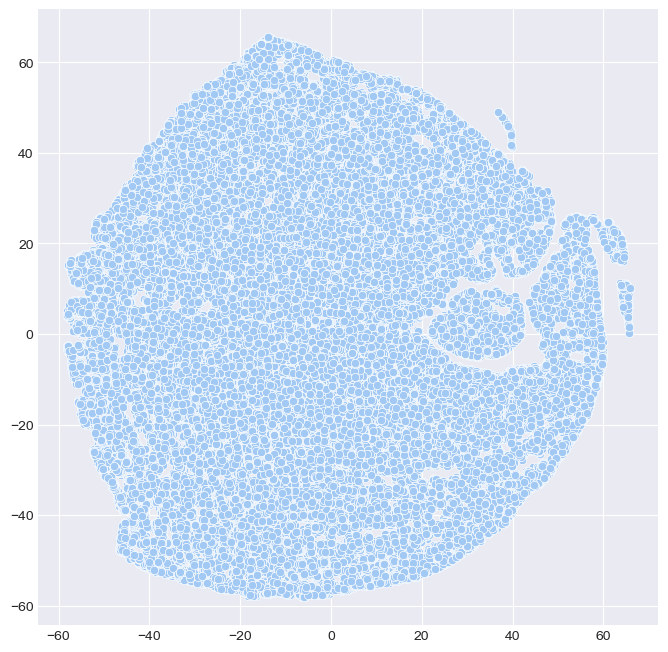

In [365]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, n_jobs=-1, init="pca", verbose=1)
T = tsne.fit_transform(rfm_projected)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1])

There are two main clusters, we'll see if we can visualize better relationships with more features

### PCA on additional features

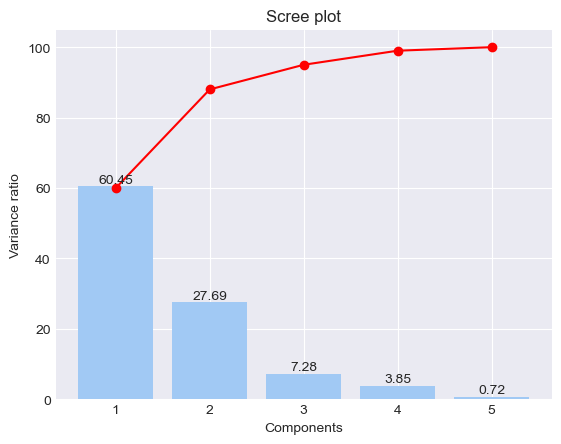

In [342]:
subset = customers[
    ["order_frequency", "total_price", "recency", "review_score", "comment"]
]

subset_pca = PCA(n_components=5)
scaled_data = scale(subset)
subset_pca.fit(scaled_data)
scree_plot(subset_pca, 5)

With this subset of features, the first component explains a significant percentage of the variance 

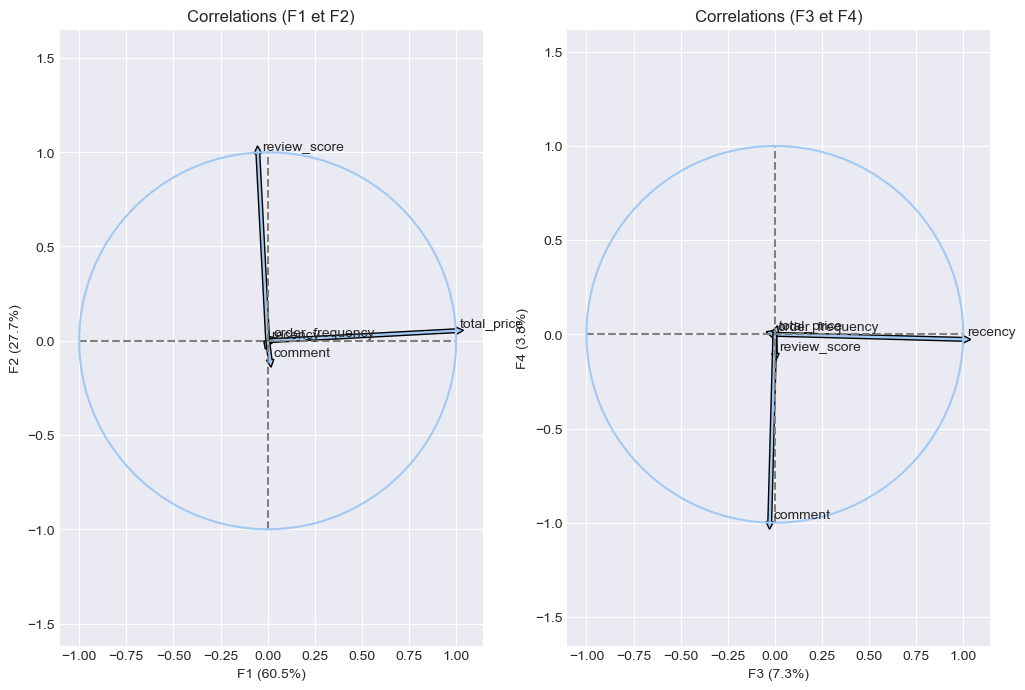

In [343]:
plot_correlation_circle(subset_pca, subset.columns, [(0, 1), (2, 3)])

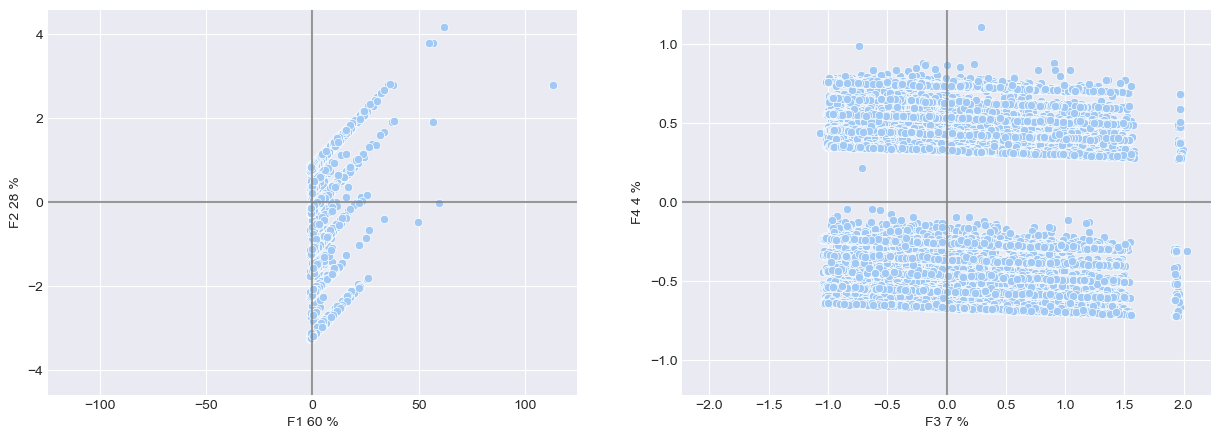

In [344]:
subset_projected_values = pca.transform(scaled_data)

display_factorial_planes(
    subset_projected_values,
    [(0, 1), (2, 3)],
    pca,
)

In [345]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, n_jobs=-1, init="pca", verbose=1)
T = tsne.fit_transform(subset_projected_values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93358 samples in 0.032s...
[t-SNE] Computed neighbors for 93358 samples in 0.828s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93358
[t-SNE] Computed conditional probabilities for sample 2000 / 93358
[t-SNE] Computed conditional probabilities for sample 3000 / 93358
[t-SNE] Computed conditional probabilities for sample 4000 / 93358
[t-SNE] Computed conditional probabilities for sample 5000 / 93358
[t-SNE] Computed conditional probabilities for sample 6000 / 93358
[t-SNE] Computed conditional probabilities for sample 7000 / 93358
[t-SNE] Computed conditional probabilities for sample 8000 / 93358
[t-SNE] Computed conditional probabilities for sample 9000 / 93358
[t-SNE] Computed conditional probabilities for sample 10000 / 93358
[t-SNE] Computed conditional probabilities for sample 11000 / 93358
[t-SNE] Computed conditional probabilities for sample 12000 / 93358
[t-SNE] Computed conditional probabilities for sam

<Axes: >

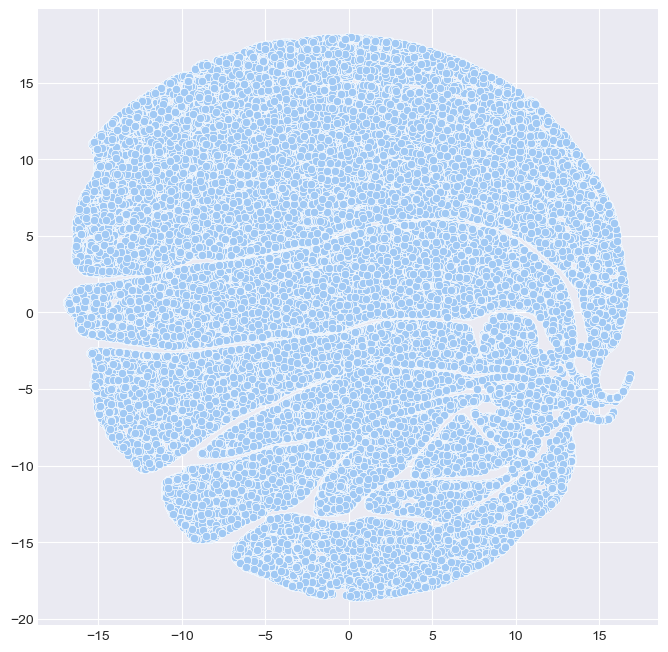

In [348]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=T[:, 0], y=T[:, 1])

The clusters are more evident 

# Models 

Let's first focus on RFM related features 

In [303]:
rfm = transformed_customers[["recency", "total_price", "order_frequency"]]
rfm

,recency,total_price,order_frequency
0,2.049218,2.155032,0.30103
1,2.060698,1.450095,0.30103
2,2.729974,1.940616,0.30103
3,2.506505,1.649530,0.30103
4,2.459392,2.296424,0.30103
...,...,...,...
93353,2.650308,3.315639,0.30103
93354,2.418301,1.932372,0.30103
93355,2.754348,2.054843,0.30103
93356,2.075547,2.129335,0.30103


In [304]:
scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(rfm)

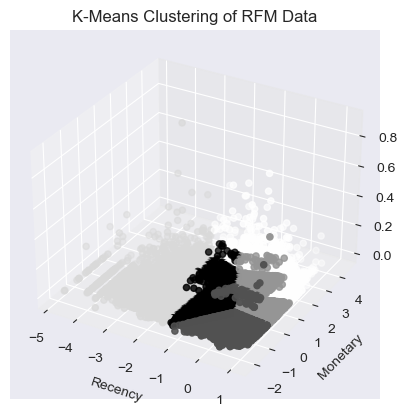

In [305]:
model = KMeans(5, n_init="auto")
model.fit(rfm)
clusters = model.predict(rfm)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(rfm_scaled[:, 0], rfm_scaled[:, 1], rfm_scaled[:, 2], c=clusters)

ax.set_xlabel("Recency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Frequency")

handles = [
    plt.Line2D([0], [0], marker="o", color="w",
               markerfacecolor=c, markersize=10)
    for c in plt.cm.viridis.colors
]

plt.title("K-Means Clustering of RFM Data")
plt.show()